<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [378]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [379]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [380]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)


    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z / torch.exp(self.s)
        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [381]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

train_data = Data(X_train)


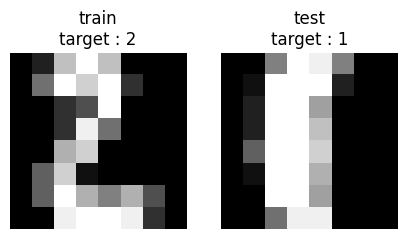

In [382]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [383]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=200, shuffle=True)


In [384]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  93.01819501604352
Epoch :  2   -----------> Loss :  88.98071180071149
Epoch :  3   -----------> Loss :  86.40144457135882
Epoch :  4   -----------> Loss :  84.18558829171317
Epoch :  5   -----------> Loss :  81.91664014543805
Epoch :  6   -----------> Loss :  79.59955814906529
Epoch :  7   -----------> Loss :  77.32353210449219
Epoch :  8   -----------> Loss :  75.04022434779576
Epoch :  9   -----------> Loss :  72.77556392124721
Epoch :  10   -----------> Loss :  70.56172398158482
Epoch :  11   -----------> Loss :  68.31011526925224
Epoch :  12   -----------> Loss :  66.09657505580357
Epoch :  13   -----------> Loss :  63.84698595319475
Epoch :  14   -----------> Loss :  61.60314287458147
Epoch :  15   -----------> Loss :  59.46600941249302
Epoch :  16   -----------> Loss :  57.390580313546316
Epoch :  17   -----------> Loss :  55.14050946916853
Epoch :  18   -----------> Loss :  52.93524006434849
Epoch :  19   -----------> Loss :  50.97081865583147
E

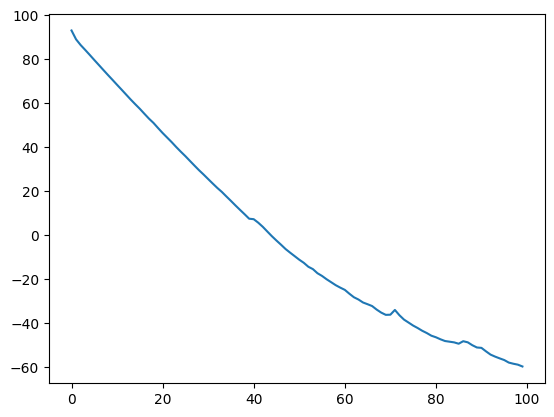

In [385]:
plt.plot(COST)

In [386]:
test = prior.sample((50,))
test

tensor([[-0.6199,  0.0716,  0.3458,  ...,  0.5860, -1.1882, -0.1158],
        [ 0.3808,  0.2913, -1.5716,  ...,  0.7191,  0.2658, -0.4222],
        [-0.4688, -0.6503,  0.1170,  ...,  1.7877,  0.1511, -0.7390],
        ...,
        [-1.2388,  1.2833,  0.2309,  ..., -2.3784,  0.2166,  0.7873],
        [ 0.5190,  0.2735, -0.1657,  ...,  0.6720, -0.3186, -1.0997],
        [ 0.5973, -1.3440, -1.1811,  ...,  1.3830,  0.2513,  0.9462]])

In [387]:
sonuc = model.f_inv(test)
sonuc

tensor([[-0.0311,  0.0178,  0.3753,  ...,  0.6846,  0.2633, -0.0340],
        [ 0.0171,  0.0530,  0.1953,  ...,  0.5061,  0.2998, -0.0696],
        [-0.0286, -0.0455,  0.0475,  ...,  0.8706,  0.1134, -0.0795],
        ...,
        [-0.0657,  0.0713,  0.2128,  ...,  0.0487,  0.3114,  0.0203],
        [ 0.0090,  0.1057,  0.6423,  ...,  0.4337,  0.4416, -0.0617],
        [ 0.0245, -0.0908,  0.0063,  ...,  0.7334,  0.5571,  0.0219]],
       grad_fn=<CopySlices>)

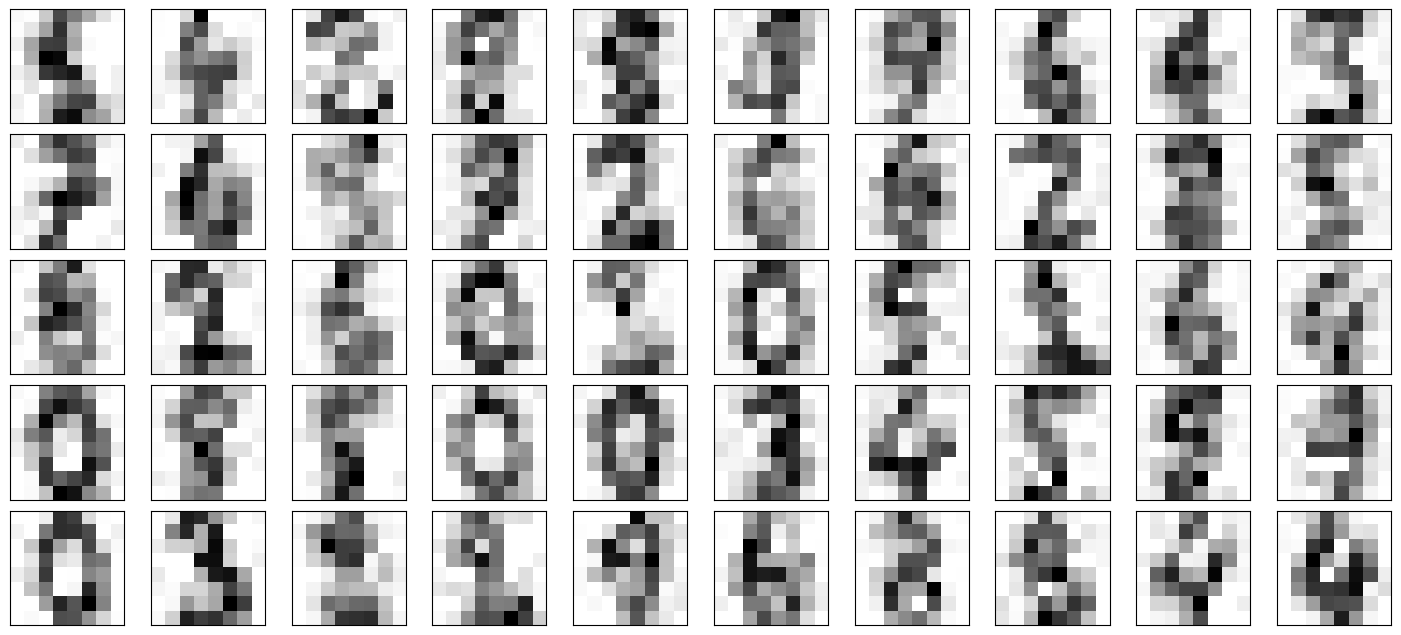

In [388]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
fig.show()


In [389]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [390]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [391]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(450, 2)


In [392]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(450, 2)


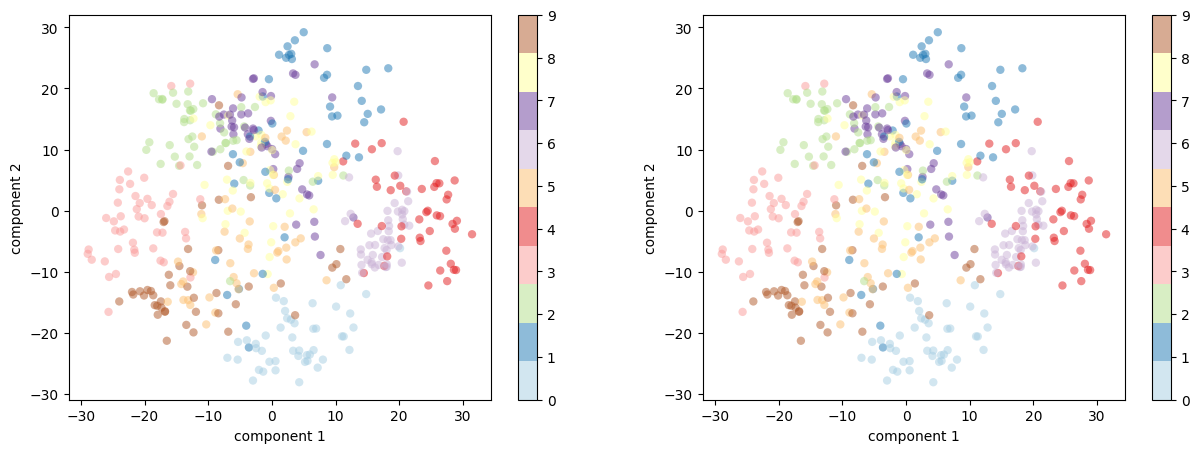

In [393]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()